# Libraries

In [391]:
import pandas as pd
from pandas_profiling import ProfileReport
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, \
                            IsolationForest, StackingClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, SimpleImputer, IterativeImputer
from sklearn.metrics import confusion_matrix, plot_roc_curve, accuracy_score
from sklearn.tree import DecisionTreeClassifier

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

import xgboost as xgb
import lightgbm as lgb

# Setup

In [392]:
pd.set_option('display.max_rows', 50)

# Load data

In [435]:
data = pd.read_csv('./data/train.csv')
test_data = pd.read_csv('./data/test.csv')


data.drop(['Ticket'], axis=1, inplace=True)
# data = data.dropna(thresh=9).reset_index()

print(data.shape)

(100000, 11)


<AxesSubplot:xlabel='Age', ylabel='Count'>

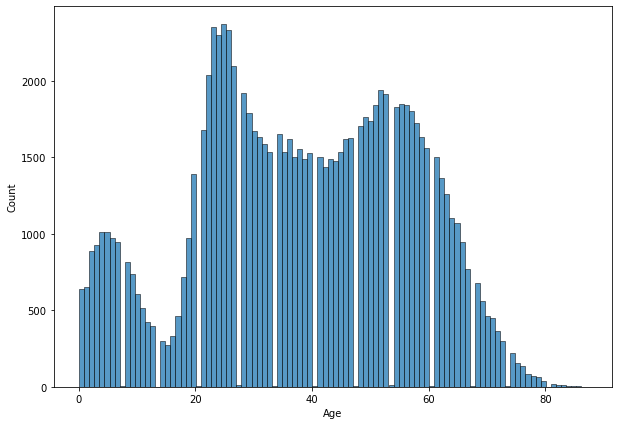

In [436]:
plt.figure(figsize=(10, 7))
sns.histplot(data['Age'], bins=100)

In [437]:
print(data.isnull().sum())

PassengerId        0
Survived           0
Pclass             0
Name               0
Sex                0
Age             3292
SibSp              0
Parch              0
Fare             134
Cabin          67866
Embarked         250
dtype: int64


In [438]:
# profile = ProfileReport(data, title='Pandas Profiling Report', explorative=True)
# profile.to_notebook_iframe()

## Description of the attributes

* PassengerId - Unique passenger id
* Survived - Flag whether passenger survived or not
* Pclass - Ticket class
* Name - Name of the passenger
* Sex - Gender of the passenger
* Age - Age of the passenger
* SibSp - # of siblings / spouses aboard the Titanic:
    * Siblings: brother, sister, stepbrother, stepsister
    * Spouse: husband, wife (mistresses and fiancés were ignored)
* Parch - # of parents / children aboard the Titanic:
    * Parent: mother, father
    * Child: daughter, son, stepdaughter, stepson
* Ticket - Ticket number
* Fare - Passenger fare
* Cabin - Cabin number
* Embarked - Port of embarkation:
    * C = Cherbourg
    * Q = Queenstown
    * S = Southampton

In [439]:
data.describe(include='all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
count,100000.000000,100000.000000,100000.000000,100000,100000,96708.000000,100000.000000,100000.000000,99866.00000,32134,99750
unique,NaN,NaN,NaN,92144,2,NaN,NaN,NaN,NaN,26992,3
top,NaN,NaN,NaN,"Johnson, John",male,NaN,NaN,NaN,NaN,C19828,S
freq,NaN,NaN,NaN,31,56114,NaN,NaN,NaN,NaN,6,72139
mean,49999.500000,0.427740,2.106910,NaN,NaN,38.355472,0.397690,0.454560,43.92933,NaN,NaN
std,28867.657797,0.494753,0.837727,NaN,NaN,18.313556,0.862566,0.950076,69.58882,NaN,NaN
min,0.000000,0.000000,1.000000,NaN,NaN,0.080000,0.000000,0.000000,0.68000,NaN,NaN
25%,24999.750000,0.000000,1.000000,NaN,NaN,25.000000,0.000000,0.000000,10.04000,NaN,NaN
50%,49999.500000,0.000000,2.000000,NaN,NaN,39.000000,0.000000,0.000000,24.46000,NaN,NaN
75%,74999.250000,1.000000,3.000000,NaN,NaN,53.000000,1.000000,1.000000,33.50000,NaN,NaN


## Null values

In [440]:
data.isna().sum()

PassengerId        0
Survived           0
Pclass             0
Name               0
Sex                0
Age             3292
SibSp              0
Parch              0
Fare             134
Cabin          67866
Embarked         250
dtype: int64

## Unique values

In [441]:
data.nunique()

PassengerId    100000
Survived            2
Pclass              3
Name            92144
Sex                 2
Age               173
SibSp               7
Parch               8
Fare            15935
Cabin           26992
Embarked            3
dtype: int64

## Variable encoding

In [442]:
# sex -> gender
sex_encoder = LabelEncoder()
sex_encoder.fit(data[['Sex']])
data['Gender'] = sex_encoder.transform(data[['Sex']])

# embarked -> origin
emb_encoder = LabelEncoder()
emb_encoder.fit((data[['Embarked']].append(test_data[['Embarked']])).astype(str))
data['Origin'] = emb_encoder.transform(data[['Embarked']].astype(str))
data.loc[data['Embarked'].isnull(), 'Origin'] = np.nan
# data['Origin'] = data['Origin'].replace('nan', np.nan)

data['Family_Members'] = data['SibSp'] + data['Parch']
data[['Surname', 'Firstname']] = data.Name.str.split(", ", expand=True)
test_data[['Surname', 'Firstname']] = test_data.Name.str.split(", ", expand=True)

# cabin -> cabin_letter_enc
cabin_encoder = LabelEncoder()
data['Cabin_Letter'] = data.Cabin.str.slice(0, 1)
cabin_encoder.fit(data[['Cabin_Letter']].astype(str))
data['Cabin_Letter_Enc'] = cabin_encoder.transform(data[['Cabin_Letter']].astype(str))
# data['Cabin_Letter_Enc'] = data['Cabin_Letter_Enc'].replace('nan', np.nan)
data.loc[data['Cabin_Letter'].isnull(), 'Cabin_Letter_Enc'] = np.nan

# surname -> surname_enc
surname_encoder = LabelEncoder()
surname_encoder.fit((data[['Surname']].append(test_data[['Surname']], ignore_index=True)).astype(str))
data['Surname_Enc'] = surname_encoder.transform(data[['Surname']].astype(str))
# data['Surname_Enc'] = data['Surname_Enc'].replace('nan', np.nan)
data.loc[data['Surname'].isnull(), 'Surname_Enc'] = np.nan


data['Fare_Log'] = np.log1p(data['Fare'])
data['Is_Alone'] = np.where(data['Family_Members'] == 0, 1, 0)
data['Age_Bins'] = np.where(data['Age'] <= 18, 1, 
#                                  np.where(data['Age'] <= 40, 2,
#                                  np.where(data['Age'] <= 45, 3,
#                                  np.where(data['Age'] <= 60, 4,
                                 np.where(data['Age'] <= 40, 2, 3))
# )))

/Users/educauchy/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [443]:
data.isnull().sum()

PassengerId             0
Survived                0
Pclass                  0
Name                    0
Sex                     0
Age                  3292
SibSp                   0
Parch                   0
Fare                  134
Cabin               67866
Embarked              250
Gender                  0
Origin                250
Family_Members          0
Surname                 0
Firstname               0
Cabin_Letter        67866
Cabin_Letter_Enc    67866
Surname_Enc             0
Fare_Log              134
Is_Alone                0
Age_Bins                0
dtype: int64

# Imputation

In [448]:
cols = ['Pclass', 'Age', 'SibSp', 'Parch','Family_Members', 'Fare', \
        'Gender','Surname_Enc', 'Origin', 'Is_Alone', 'Fare_Log', 'Age_Bins', 'Cabin_Letter_Enc']

# imputer = KNNImputer(n_neighbors=5)
imputer = IterativeImputer()
imputer.fit(data[cols])
data_imputed = imputer.transform(data[cols])

data_train = pd.DataFrame(data = data_imputed, columns = cols)
data_train['Survived'] = data['Survived']

data_train.shape

(100000, 14)

# Anomaly Detection

In [449]:
clf_anomaly = IsolationForest(n_estimators=100, n_jobs=-1, random_state=0).fit(data_train)
pred_anomaly = clf_anomaly.predict(data_train)
data_train = data_train[pred_anomaly == 1]

print(data_train.shape)
print(len(data) - len(data_train))

(61273, 14)
38727


# Model

In [451]:
X = data_train[data_train.columns[~data_train.columns.isin(['Survived'])]]
y = data_train['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0)

print(X_train.head())
print(y_train.head())
print(X_test.head())
print(y_test.head())

clf = RandomForestClassifier(n_estimators=100, criterion='entropy', \
                            random_state=0, oob_score=True, n_jobs=-1).fit(X_train, y_train)

# clf = AdaBoostClassifier(n_estimators=4000).fit(X_train, y_train)
# clf = GradientBoostingClassifier(n_estimators=1500).fit(X_train, y_train)

print(clf.score(X_test, y_test))
print(pd.DataFrame(np.array(list(zip(cols, np.round(clf.feature_importances_, 3)))), columns=['Feature', 'Importance']).sort_values(by='Importance', ascending=False))


       Pclass   Age  SibSp  Parch  Family_Members   Fare  Gender  Surname_Enc  \
25533     3.0  58.0    0.0    0.0             0.0  24.51     0.0       8424.0   
46735     3.0  32.0    1.0    0.0             1.0   8.01     1.0      15495.0   
4265      2.0  30.0    0.0    0.0             0.0  27.11     0.0       6826.0   
72857     3.0  26.0    1.0    0.0             1.0  10.49     1.0       4310.0   
93457     1.0  55.0    0.0    0.0             0.0  25.19     1.0      13536.0   

       Origin  Is_Alone  Fare_Log  Age_Bins  Cabin_Letter_Enc  
25533     2.0       1.0  3.239071       3.0          3.039617  
46735     2.0       0.0  2.198335       2.0          2.662313  
4265      0.0       1.0  3.336125       2.0          4.000000  
72857     2.0       0.0  2.441477       2.0          2.545690  
93457     2.0       1.0  3.265378       3.0          3.000000  
25533    1
46735    0
4265     1
72857    0
93457    1
Name: Survived, dtype: int64
       Pclass   Age  SibSp  Parch  Family_Mem

### XGBOOST

In [405]:
# dtrain = xgb.DMatrix(X, label=y)
# dtest = xgb.DMatrix(test_data_test[data_train.columns[~data_train.columns.isin(['Survived', 'PassengerId'])]])
# param = {'max_depth': 2, 'eta': 1, 'objective': 'binary:logistic'}
# num_round = 3
# bst = xgb.train(param, dtrain, num_round)
# preds = bst.predict(dtest)

## Model Accuracy

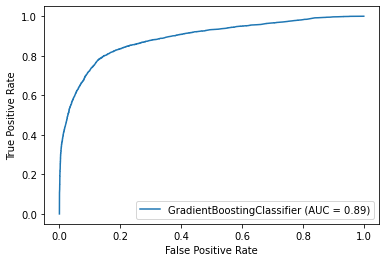

In [406]:
plot_roc_curve(clf, X_test, y_test)

# Predict test

In [407]:
test_data['Gender'] = sex_encoder.transform(test_data[['Sex']])

test_data['Origin'] = emb_encoder.transform(test_data[['Embarked']].astype(str))
# test_data['Origin'] = test_data['Origin'].replace('nan', np.nan)
test_data.loc[test_data['Embarked'].isnull(), 'Origin'] = np.nan

test_data['Family_Members'] = test_data['SibSp'] + test_data['Parch']

test_data['Surname_Enc'] = surname_encoder.transform(test_data[['Surname']].astype(str))
# test_data['Surname_Enc'] = test_data['Surname_Enc'].replace('nan', np.nan)
test_data.loc[test_data['Surname'].isnull(), 'Surname_Enc'] = np.nan

# cabin -> cabin_letter_enc
test_data['Cabin_Letter'] = test_data.Cabin.str.slice(0, 1)
test_data['Cabin_Letter_Enc'] = cabin_encoder.transform(test_data['Cabin_Letter'].astype(str))
test_data.loc[test_data['Cabin_Letter'].isnull(), 'Cabin_Letter_Enc'] = np.nan

test_data['Family_Members'] = test_data['SibSp'] + test_data['Parch']
test_data['Fare_Log'] = np.log1p(test_data['Fare'])
test_data['Is_Alone'] = np.where(test_data['Family_Members'] == 0, 1, 0)
test_data['Age_Bins'] = np.where(test_data['Age'] <= 18, 1, 
#                                  np.where(test_data['Age'] <= 30, 2,
#                                  np.where(test_data['Age'] <= 45, 3,
#                                  np.where(test_data['Age'] <= 60, 4,
                                 np.where(test_data['Age'] <= 40, 2, 3))
#                                          )))

/Users/educauchy/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [408]:
test_data_imputed = imputer.transform(test_data[cols])
test_data_test = pd.DataFrame(data = test_data_imputed, columns = cols)
test_data_test.head()

,Pclass,Age,SibSp,Parch,Family_Members,Fare,Gender,Surname_Enc,Origin,Is_Alone,Fare_Log,Age_Bins,Cabin_Letter_Enc
0,3.0,19.0,0.0,0.0,0.0,63.01,1.0,10830.0,2.0,1.0,4.159039,2.0,1.4
1,3.0,53.0,0.0,0.0,0.0,5.81,0.0,17134.0,2.0,1.0,1.918392,3.0,2.8
2,1.0,19.0,0.0,0.0,0.0,38.91,0.0,9978.0,0.0,1.0,3.686627,2.0,1.0
3,2.0,25.0,0.0,0.0,0.0,12.93,1.0,13303.0,2.0,1.0,2.634045,2.0,1.4
4,1.0,17.0,0.0,2.0,2.0,26.89,0.0,4406.0,0.0,0.0,3.328268,1.0,1.0


In [424]:
test_data_test['Survived'] = clf.predict(test_data_test[cols]).astype(int)
test_data_test['PassengerId'] = test_data['PassengerId'].astype(int)
test_data_test[['PassengerId', 'Survived']].to_csv('./submissions/GBM3_noTicket_kNNImpute_IsoForest_16_04.csv', index = False)